# Импорт библиотек

In [175]:
import numpy as np
from sympy import Poly
from sympy.abc import y
import matplotlib.pyplot as plt
from sympy import plotting
from sympy import symbols
from scipy import interpolate

# 1) Решение методом неопределенных коэффициентов

## Задание матрицы для СЛАУ и значений функции в точках

### В условии задачи даны значения функции в пяти точках. Зададим эти точки, также зададим матрицу для нахождения коэффициентов

In [176]:
x = np.array([0, 1, 3, 4, 5])
f = np.array([0.5, 0.3, 0.3, 0.2, 0.1])
point = 5
# Шаг принимаем единичный
h = 1

A = np.array([[1, 1, 1, 1, 1],
              [-3, -2, -1, 0, 1],
              [9, 4, 1, 0, 1],    
              [-27, -8, -1, 0, 1],
              [81, 16, 1, 0, 1]])

b = np.array([0, 1, 0, 0, 0])


## Вычисление коэффициентов

In [177]:
coefficients = np.linalg.inv(A).dot(b)

print('Вычисленные коэффициенты:')
print(coefficients)

Вычисленные коэффициенты:
[-0.08333333  0.5        -1.5         0.83333333  0.25      ]


## Вычисление производной с помощью неопределенных коэффициентов

In [178]:
def derivative_coefficients(f, h, coefficients):
    f_derivative = 0
    for i in range(len(coefficients) - 1):
        f_derivative += coefficients[i] * f[i]
        
    return 1.0 * f_derivative / h
    
f_derivative_with_coefficients = derivative_coefficients(f, h, coefficients)
print(f_derivative_with_coefficients)

-0.175


# 2) Решение методом интерполяции

## Построение таблицы разделенных разностей

In [179]:
class DifferenceTable:
    def __init__(self, f, x):
        self.length = len(f)
        self.b_0 = f.copy()
        self.b_1 = [(self.b_0[i + 1] - self.b_0[i]) / (x[i + 1] - x[i]) for i in range(self.length - 1) if i < 4]
        self.b_2 = [(self.b_1[i + 1] - self.b_1[i]) / (x[i + 2] - x[i]) for i in range(self.length - 1) if i < 3]
        self.b_3 = [(self.b_2[i + 1] - self.b_2[i]) / (x[i + 3] - x[i]) for i in range(self.length - 1) if i < 2]
        self.b_4 = [(self.b_3[i + 1] - self.b_3[i]) / (x[i + 4] - x[i]) for i in range(self.length - 1) if i < 1]
        
        self.columns = []
        self.columns.append(self.b_0)
        self.columns.append(self.b_1)
        self.columns.append(self.b_2)
        self.columns.append(self.b_3)
        self.columns.append(self.b_4)
        
    def show(self):
        for column in self.columns:
            print(column)
        
    def get_coefficients_low(self):
        return [column[-1] for column in self.columns]
        
table = DifferenceTable(f, x)
table.show()

[0.5 0.3 0.3 0.2 0.1]
[-0.2, 0.0, -0.09999999999999998, -0.1]
[0.06666666666666667, -0.033333333333333326, -1.3877787807814457e-17]
[-0.024999999999999998, 0.008333333333333328]
[0.006666666666666665]


## Построение многочлена и вычисление от него производной

In [180]:
coefficients = table.get_coefficients_low()
print(coefficients)

poly = Poly(coefficients[0] + coefficients[1] * (y - x[4]) +
            coefficients[2] * (y - x[4]) * (y - x[3]) + 
            coefficients[3] * (y - x[4]) * (y - x[3]) * (y - x[2]) +
            coefficients[4] * (y - x[4]) * (y - x[3]) * (y - x[2]) * (y - x[1]))

poly

t = symbols('t')
poly_as_func = 0.00666666666666667 * t**4 - 0.0783333333333333 * t**3 + 0.293333333333333 * t**2 - 0.421666666666667 * t + 0.5

[0.1, -0.1, -1.3877787807814457e-17, 0.008333333333333328, 0.006666666666666665]


In [181]:
differentiated = poly.diff()
differentiated

Poly(0.0266666666666667*y**3 - 0.235*y**2 + 0.586666666666667*y - 0.421666666666667, y, domain='RR')

In [182]:
print(differentiated(point))

-0.0299999999999986


## Немного графики

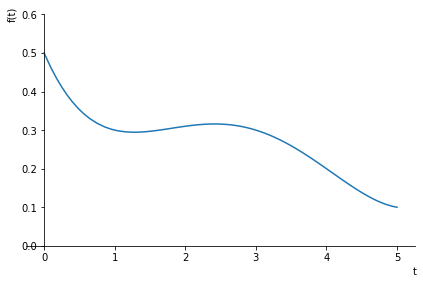

In [183]:

plot = plotting.plot(poly_as_func, (t, 0, 5), ylim = [0, 0.6], axis_center = (0, 0))


# 3) Вычисление с помощью сплайн-интерполяции

[ 3.33066907e-17 -2.00000000e-01  5.00000000e-01  1.00000000e-01
 -4.00000000e-01  6.00000000e-01 -3.00000000e-01  2.00000000e+00
 -3.00000000e+00  3.00000000e-01 -2.80000000e+00  6.60000000e+00]
0.5 - 0.2·x¹ + 3.3306690738754695e-17·x²
0.5999999999999999 - 0.3999999999999998·x¹ + 0.09999999999999991·x²
-2.999999999999999 + 1.9999999999999987·x¹ - 0.2999999999999999·x²
6.600000000000004 - 2.800000000000003·x¹ + 0.3000000000000005·x²


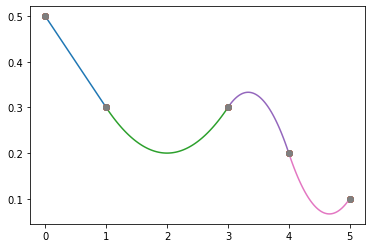

In [184]:


spline_coeffs = np.array([[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                            [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                            [0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0],
                            [0, 0, 0, 9, 3, 1, 0, 0, 0, 0, 0, 0],
                            [0, 0, 0, 0, 0, 0, 9, 3, 1, 0, 0, 0],
                            [0, 0, 0, 0, 0, 0, 16, 4, 1, 0, 0, 0],
                            [0, 0, 0, 0, 0, 0, 0, 0, 0, 16, 4, 1],
                            [0, 0, 0, 0, 0, 0, 0, 0, 0, 25, 5, 1],
                            [2, 1, 0, -2, -1, 0, 0, 0, 0, 0, 0, 0],
                            [0, 0, 0, 6, 1, 0, -6, -1, 0, 0, 0, 0],
                            [0, 0, 0, 0, 0, 0, 8, 1, 0, -8, -1, 0],
                            [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

values = np.array([0.5, 0.3, 0.3, 0.3, 0.3, 0.2, 0.2, 0.1, 0, 0, 0, 0])

solution = (np.linalg.inv(spline_coeffs)).dot(values)

print(solution)

spline_1 = solution[0:3]
spline_2 = solution[3:6]
spline_3 = solution[6:9]
spline_4 = solution[9:12]

splines = [spline_1, spline_2, spline_3, spline_4]
# print(spline_1)
# print(spline_2)
# print(spline_3)
# print(spline_4)

poly_1 = np.polynomial.Polynomial(spline_1[::-1])
print(poly_1)
poly_2 = np.polynomial.Polynomial(spline_2[::-1])
print(poly_2)
poly_3 = np.polynomial.Polynomial(spline_3[::-1])
print(poly_3)
poly_4 = np.polynomial.Polynomial(spline_4[::-1])
print(poly_4)
               
polys = [poly_1, poly_2, poly_3, poly_4]
    
for i in range(0, 4):
    t = np.linspace(x[i], x[i + 1], 100)
    plt.plot(t, polys[i](t), '-', x, f, 'o')

### Получилась пушечка после 4 часов отгадывания, как это запрогать, все же не запрогал и руками посчитал. Теперь вычислим производную в точке 5 и, очевидно, получим совершенно другое значение

In [185]:
derivative_with_spline = np.polynomial.Polynomial.deriv(poly_4)(point)
print(derivative_with_spline)

0.20000000000000195


## Сравнение с питоновской интерполяцией

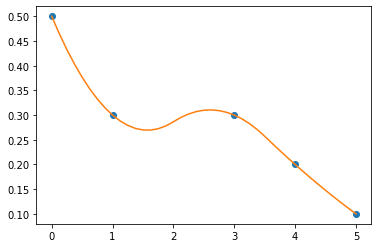

In [186]:
canonical_interpolation = interpolate.interp1d(x, f, kind = 'quadratic')
print(canonical_interpolation)

xnew = np.linspace(0, 5, num=41, endpoint=True)
plt.plot(x, f, 'o', xnew, canonical_interpolation(xnew), '-')

# 4) Обсуждение результатов

В случае глобальной интерполяции многочленом Ньютона, производная немного отличается по сравнению с методом неопределенных коэффициентов, а в случае в интерполяцией локальной квадратичными сплайнами значение производной еще и поменяло знак. Связано это с тем, что при локальнок интерполяции мы точнее определяем полиномы, задающие функцию на каждом отдельном отрезке.